# Dataset Analysis 

In [1]:
import pypyodbc as odbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv(".env", override=True)

DRIVER_NAME = os.getenv("DRIVER_NAME")
SERVER_NAME = os.getenv("SERVER_NAME")
DATABASE_NAME = os.getenv("DATABASE_NAME")
connection_string = f'DRIVER={{{DRIVER_NAME}}};SERVER={SERVER_NAME};DATABASE={DATABASE_NAME};Trusted_Connection=yes;'
conn= odbc.connect(connection_string)

## I. Schema Exploration

In [2]:
group_schema= """ SELECT COUNT(*) AS TotalTables
FROM sys.tables
WHERE is_ms_shipped = 0; -- Excludes system tables

-- Get tables grouped by schema with counts

"""
schema = """
SELECT
s.name AS SchemaName,
COUNT(t.object_id) AS TableCount
FROM sys.tables t
INNER JOIN sys.schemas s ON t.schema_id = s.schema_id
WHERE t.is_ms_shipped = 0 -- Exclude system tables
GROUP BY s.name
ORDER BY s.name;
"""
group_schema_df = pd.read_sql(group_schema, conn)
schema_df = pd.read_sql(schema, conn)

C:\Users\User\AppData\Local\Temp\ipykernel_80284\1270170524.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  group_schema_df = pd.read_sql(group_schema, conn)
C:\Users\User\AppData\Local\Temp\ipykernel_80284\1270170524.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  schema_df = pd.read_sql(schema, conn)


In [3]:
print(schema_df)
print("----------------------------------------------")
print(group_schema_df)


       schemaname  tablecount
0             dbo           4
1  HumanResources           6
2          Person          13
3      Production          25
4      Purchasing           5
5           Sales          19
----------------------------------------------
   totaltables
0           72


## II. Data exploration
### 1/Row Counts


In [4]:
script = """
SELECT
    * 
FROM (
    SELECT
        COUNT(SalesOrderID) AS OrderCount,
        CustomerID
    FROM
        Sales.SalesOrderHeader
    GROUP BY
        CustomerID
) AS CustomerOrderCounts
"""
script_df = pd.read_sql(script, conn)


C:\Users\User\AppData\Local\Temp\ipykernel_80284\1434924995.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  script_df = pd.read_sql(script, conn)


In [5]:
print(script_df.head())


   ordercount  customerid
0           3       11000
1           3       11001
2           3       11002
3           3       11003
4           3       11004


In [6]:
# Check DataFrame columns to debug KeyError
print('Columns in script_df:', script_df.columns.tolist())
print(script_df.head())

Columns in script_df: ['ordercount', 'customerid']
   ordercount  customerid
0           3       11000
1           3       11001
2           3       11002
3           3       11003
4           3       11004


### Order Frequency

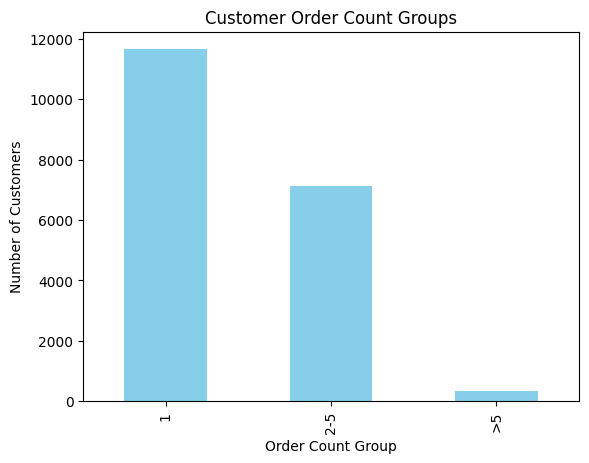

OrderCountGroup
1      11649
2-5     7133
>5       337
Name: count, dtype: int64


In [7]:
# Group order counts into bins: 1, 2-5, >5
if 'ordercount' in script_df.columns:
    bins = [0, 1, 5, float('inf')]
    labels = ['1', '2-5', '>5']
    script_df['OrderCountGroup'] = pd.cut(script_df['ordercount'], bins=bins, labels=labels, right=True)
    grouped = script_df['OrderCountGroup'].value_counts().sort_index()
    grouped.plot(kind='bar', color='skyblue')
    plt.title('Customer Order Count Groups')
    plt.xlabel('Order Count Group')
    plt.ylabel('Number of Customers')
    plt.show()
    print(grouped)
else:
    print('Column "ordercount" not found. Available columns:', script_df.columns.tolist())

### Churn rate and Class imbalance


In [9]:
churn_rate_sql= """
-- Define churn: customers with no orders in past 12 months,
WITH LastOrder AS (
SELECT CustomerID, MAX(OrderDate) AS LastPurchase
FROM Sales.SalesOrderHeader
GROUP BY CustomerID
)
SELECT
CASE
WHEN LastPurchase < DATEADD(year, -1, '2014-06-30') OR LastPurchase IS NULL THEN 'Churned'
ELSE 'Active'
END AS CustomerStatus,
COUNT(*) AS CountCustomers
FROM LastOrder
GROUP BY CASE
WHEN LastPurchase < DATEADD(year, -1, '2014-06-30') OR LastPurchase IS NULL THEN 'Churned'
ELSE 'Active'
END;
"""   

In [10]:
churn_rate_df = pd.read_sql(churn_rate_sql, conn)
print(churn_rate_df)

  customerstatus  countcustomers
0         Active           18103
1        Churned            1016


C:\Users\User\AppData\Local\Temp\ipykernel_80284\2322352234.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  churn_rate_df = pd.read_sql(churn_rate_sql, conn)


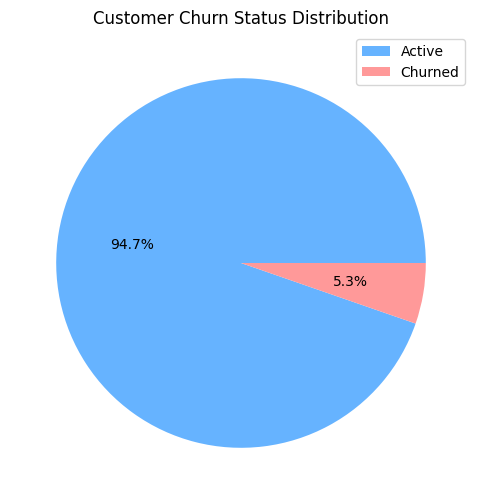

In [ ]:
plt.figure(figsize=(6, 6))
ax = churn_rate_df.set_index('customerstatus')['countcustomers'].plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], labels=None)
plt.ylabel('')
plt.title('Customer Churn Status Distribution')
plt.legend(churn_rate_df['customerstatus'], loc='best')
plt.show()

### Other visualizations


In [12]:

bar_sql = '''
SELECT 
    t.Name AS Region, 
    pc.Name AS ProductCategory, 
    SUM(soh.TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
JOIN Production.Product p ON sod.ProductID = p.ProductID
JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
JOIN Sales.SalesTerritory t ON soh.TerritoryID = t.TerritoryID
GROUP BY t.Name, pc.Name
'''
bar_df = pd.read_sql(bar_sql, conn)
print(bar_df)

C:\Users\User\AppData\Local\Temp\ipykernel_80284\758457940.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bar_df = pd.read_sql(bar_sql, conn)


            region productcategory    totalsales
0          Central        Clothing  4.749745e+07
1        Southwest           Bikes  2.885184e+08
2        Southwest        Clothing  1.279242e+08
3        Northwest           Bikes  1.716123e+08
4        Australia           Bikes  3.343216e+07
5        Northeast      Components  8.069797e+07
6        Southwest     Accessories  5.950406e+07
7        Southeast           Bikes  9.984232e+07
8          Central           Bikes  1.198172e+08
9           France        Clothing  3.595871e+07
10         Central     Accessories  2.243411e+07
11          France     Accessories  1.748239e+07
12       Southeast        Clothing  4.289130e+07
13          Canada     Accessories  4.693575e+07
14       Northwest        Clothing  6.718148e+07
15         Germany      Components  2.463591e+07
16  United Kingdom      Components  6.097724e+07
17       Southeast     Accessories  1.839760e+07
18       Australia        Clothing  9.291474e+06
19       Northwest  

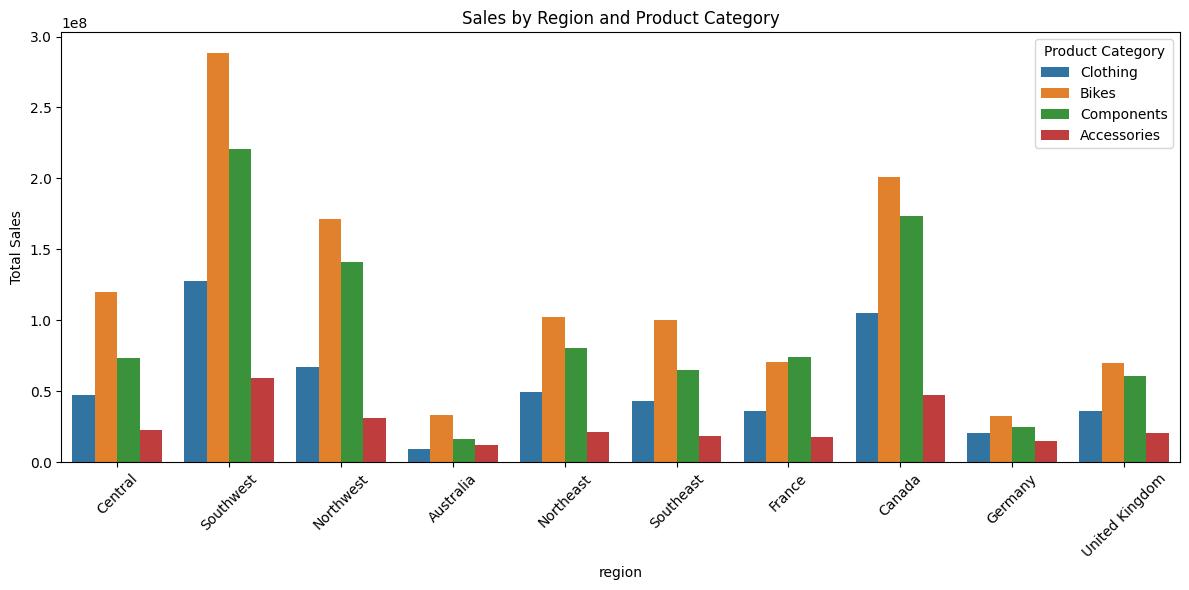

In [13]:
plt.figure(figsize=(12,6))
sns.barplot(data=bar_df, x='region', y='totalsales', hue='productcategory')
plt.title('Sales by Region and Product Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Product Category')
plt.tight_layout()
plt.show()

In [14]:
# Boxplot: customer spend distribution
# Assumes Sales.SalesOrderHeader has CustomerID and TotalDue
spend_sql = '''
SELECT CustomerID, SUM(TotalDue) AS TotalSpend
FROM Sales.SalesOrderHeader
GROUP BY CustomerID
'''
spend_df = pd.read_sql(spend_sql, conn)


C:\Users\User\AppData\Local\Temp\ipykernel_80284\1789119751.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  spend_df = pd.read_sql(spend_sql, conn)


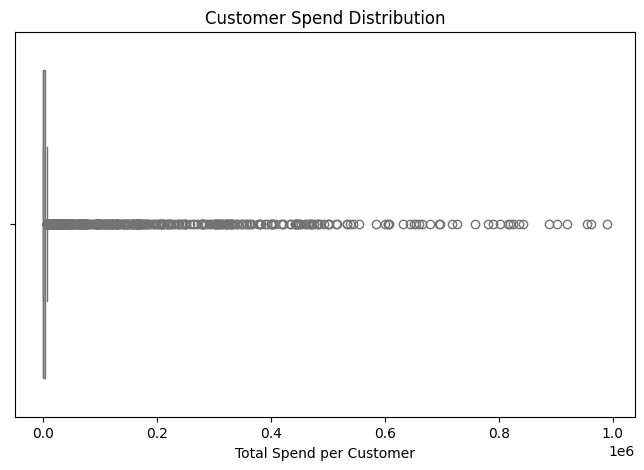

In [15]:
plt.figure(figsize=(8,5))
sns.boxplot(x=spend_df['totalspend'], color='lightgreen')
plt.title('Customer Spend Distribution')
plt.xlabel('Total Spend per Customer')
plt.show()

In [16]:
spend_df_sorted = spend_df.sort_values('totalspend', ascending=False).reset_index(drop=True)
top_20pct_count = int(0.2 * len(spend_df_sorted))
top_20pct = spend_df_sorted.iloc[:top_20pct_count]
total_revenue = spend_df_sorted['totalspend'].sum()
top_20pct_revenue = top_20pct['totalspend'].sum()
contribution_pct = 100 * top_20pct_revenue / total_revenue if total_revenue > 0 else 0
print(f"Top 20% of customers contribute {contribution_pct:.2f}% of total revenue.")

Top 20% of customers contribute 89.75% of total revenue.


In [17]:
territory_sql = '''
SELECT t.Name AS Territory, COUNT(DISTINCT c.CustomerID) AS NumCustomers
FROM Sales.Customer c
JOIN Sales.SalesTerritory t ON c.TerritoryID = t.TerritoryID
GROUP BY t.Name
ORDER BY NumCustomers DESC
'''
territory_df = pd.read_sql(territory_sql, conn)
print(territory_df)

        territory  numcustomers
0       Southwest          4696
1       Australia          3665
2       Northwest          3520
3  United Kingdom          1991
4          France          1884
5         Germany          1852
6          Canada          1791
7       Southeast           176
8         Central           132
9       Northeast           113


C:\Users\User\AppData\Local\Temp\ipykernel_80284\1376982452.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  territory_df = pd.read_sql(territory_sql, conn)


### Related to Territory

C:\Users\User\AppData\Local\Temp\ipykernel_80284\3375961464.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=territory_df, x='territory', y='numcustomers', palette=tl_palette)


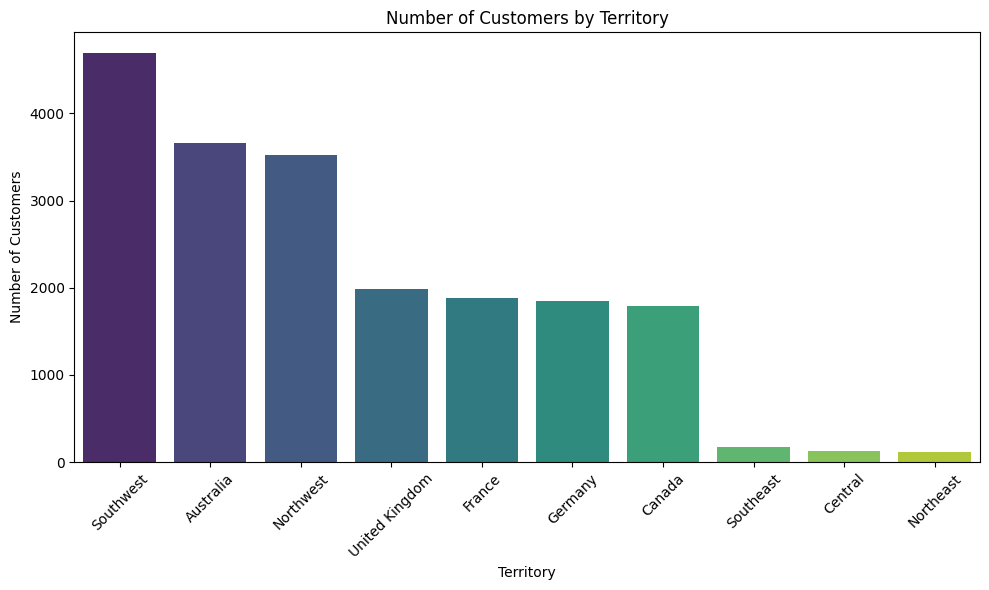

In [ ]:
tl_palette = sns.color_palette('viridis', as_cmap=False, n_colors=len(territory_df))
plt.figure(figsize=(10,6))
sns.barplot(data=territory_df, x='territory', y='numcustomers', palette=tl_palette)
plt.title('Number of Customers by Territory')
plt.xlabel('Territory')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Churn status by territory (grouped)
churn_by_territory_sql = '''
WITH LastOrder AS (
    SELECT CustomerID, MAX(OrderDate) AS LastPurchase, TerritoryID
    FROM Sales.SalesOrderHeader
    GROUP BY CustomerID, TerritoryID
)
SELECT
    t.Name AS Territory,
    CASE
        WHEN LastPurchase < DATEADD(year, -1, '2014-06-30') OR LastPurchase IS NULL THEN 'Churned'
        ELSE 'Active'
    END AS CustomerStatus,
    COUNT(*) AS CountCustomers
FROM LastOrder lo
JOIN Sales.SalesTerritory t ON lo.TerritoryID = t.TerritoryID
GROUP BY t.Name, CASE WHEN LastPurchase < DATEADD(year, -1, '2014-06-30') OR LastPurchase IS NULL THEN 'Churned' ELSE 'Active' END
ORDER BY t.Name, CustomerStatus DESC
'''
churn_territory_grouped_df = pd.read_sql(churn_by_territory_sql, conn)
print(churn_territory_grouped_df)

C:\Users\User\AppData\Local\Temp\ipykernel_80284\1877004529.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  churn_territory_grouped_df = pd.read_sql(churn_by_territory_sql, conn)


         territory customerstatus  countcustomers
0        Australia        Churned              73
1        Australia         Active            3552
2           Canada        Churned             188
3           Canada         Active            1489
4          Central        Churned              20
5          Central         Active              49
6           France        Churned              82
7           France         Active            1762
8          Germany        Churned              57
9          Germany         Active            1755
10       Northeast        Churned              11
11       Northeast         Active              46
12       Northwest        Churned             205
13       Northwest         Active            3223
14       Southeast        Churned              27
15       Southeast         Active              64
16       Southwest        Churned             298
17       Southwest         Active            4267
18  United Kingdom        Churned              55


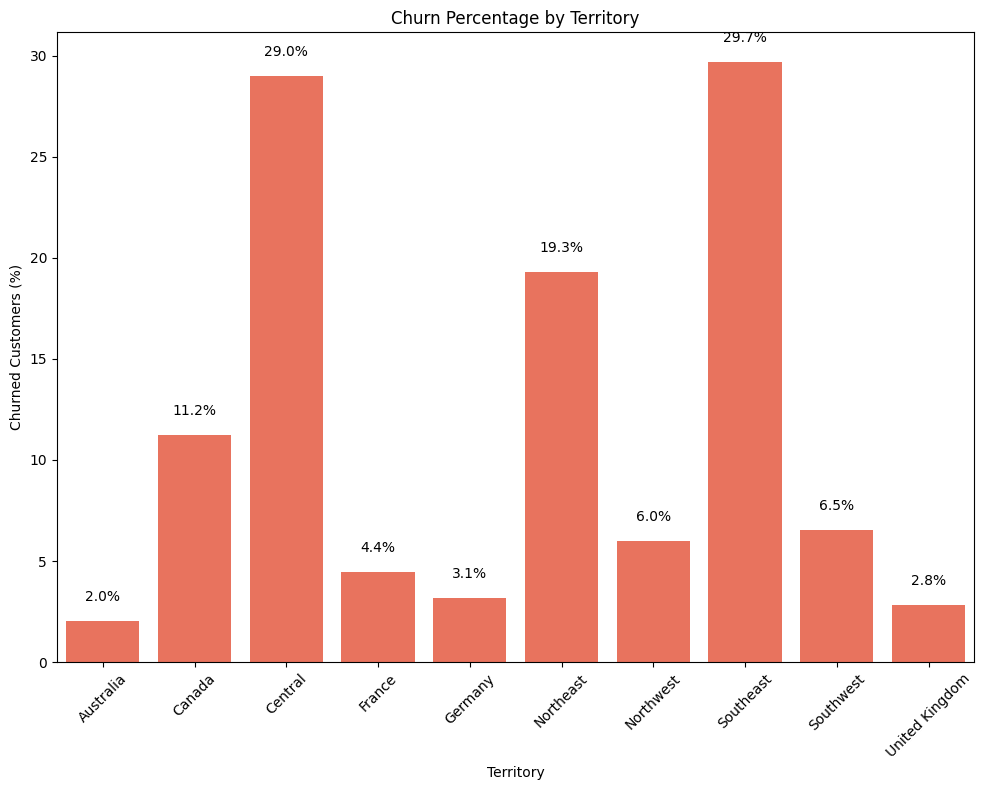

In [ ]:
churn_pct_df = churn_territory_grouped_df.pivot(index='territory', columns='customerstatus', values='countcustomers').fillna(0)
churn_pct_df['Total'] = churn_pct_df.sum(axis=1)
churn_pct_df['ChurnPct'] = 100 * churn_pct_df.get('Churned', 0) / churn_pct_df['Total']

plt.figure(figsize=(10,8))
sns.barplot(x=churn_pct_df.index, y=churn_pct_df['ChurnPct'], color='tomato')
plt.title('Churn Percentage by Territory')
plt.xlabel('Territory')
plt.ylabel('Churned Customers (%)')
plt.xticks(rotation=45)

for i, v in enumerate(churn_pct_df['ChurnPct']):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

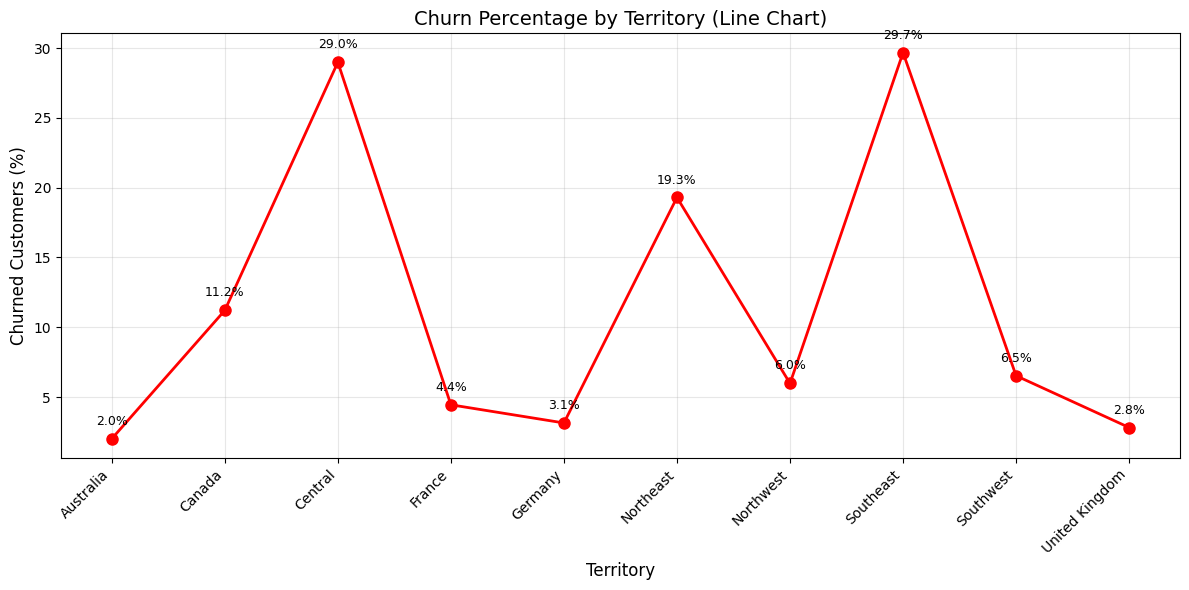

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(churn_pct_df.index, churn_pct_df['ChurnPct'], marker='o', linewidth=2, markersize=8, color='red')
plt.title('Churn Percentage by Territory (Line Chart)', fontsize=14)
plt.xlabel('Territory', fontsize=12)
plt.ylabel('Churned Customers (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add percentage labels   data points
for i, v in enumerate(churn_pct_df['ChurnPct']):
    plt.annotate(f'{v:.1f}%', (i, v), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_80284\174374873.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(territories, rotation=45, ha='right')


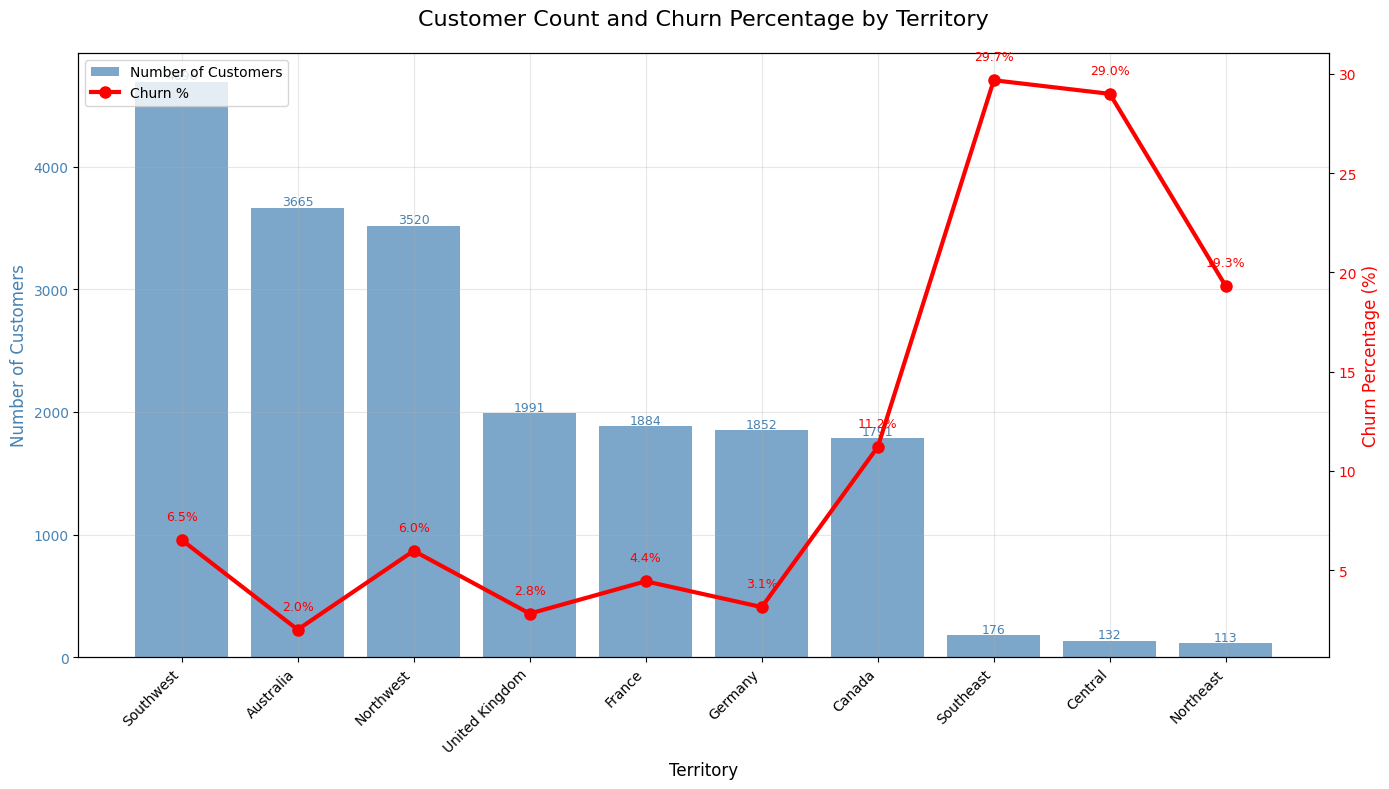

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 8))

combined_df = territory_df.set_index('territory').join(churn_pct_df['ChurnPct'], how='inner')
territories = combined_df.index

color1 = 'steelblue'
ax1.set_xlabel('Territory', fontsize=12)
ax1.set_ylabel('Number of Customers', color=color1, fontsize=12)
bars = ax1.bar(territories, combined_df['numcustomers'], color=color1, alpha=0.7, label='Number of Customers')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticklabels(territories, rotation=45, ha='right')

ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('Churn Percentage (%)', color=color2, fontsize=12)
line = ax2.plot(territories, combined_df['ChurnPct'], color=color2, marker='o', linewidth=3, markersize=8, label='Churn %')
ax2.tick_params(axis='y', labelcolor=color2)

# Add value labels
for i, (customers, churn) in enumerate(zip(combined_df['numcustomers'], combined_df['ChurnPct'])):
    ax1.text(i, customers + 20, f'{customers}', ha='center', fontsize=9, color=color1)
    ax2.text(i, churn + 1, f'{churn:.1f}%', ha='center', fontsize=9, color=color2)

# Title and legends
plt.title('Customer Count and Churn Percentage by Territory', fontsize=16, pad=20)
ax1.grid(True, alpha=0.3)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()